In [1]:
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'districting-data/'
filename = 'OK_county.json'

G = read_graph_from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    county_name = G.nodes[node]['NAME20']
    county_population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = county_population
    print("Node",node,"represents",county_name,"County, which had a population of",county_population,"in the 2020 census.")

Node 0 represents Washita County, which had a population of 10924 in the 2020 census.
Node 1 represents Jackson County, which had a population of 24785 in the 2020 census.
Node 2 represents Major County, which had a population of 7782 in the 2020 census.
Node 3 represents Delaware County, which had a population of 40397 in the 2020 census.
Node 4 represents Custer County, which had a population of 28513 in the 2020 census.
Node 5 represents Ellis County, which had a population of 3749 in the 2020 census.
Node 6 represents Oklahoma County, which had a population of 796292 in the 2020 census.
Node 7 represents Johnston County, which had a population of 10272 in the 2020 census.
Node 8 represents Comanche County, which had a population of 121125 in the 2020 census.
Node 9 represents Pushmataha County, which had a population of 10812 in the 2020 census.
Node 10 represents Cleveland County, which had a population of 295528 in the 2020 census.
Node 11 represents Wagoner County, which had a p

In [4]:
# we are to solve the following task:
# input: a population vector, desired number of districts k
# output: a partition of the populations into k districts (not necessarily connected!) 
#            to minimize the difference between most and least populated districts

import gurobipy as gp
from gurobipy import GRB

In [5]:
k = 5  # desired number of districts

# create model 
m = gp.Model()

# create variables
x = m.addVars( G.nodes, k, vtype=GRB.BINARY )  # x[i,j] = 1 when county i is assigned to district j
y = m.addVar()                                 # y = population of smallest district
z = m.addVar()                                 # z = population of largest district

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-03


In [6]:
# objective is to minimize absolute population deviation
m.setObjective( z - y, GRB.MINIMIZE )

# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k) ) == 1 for i in G.nodes ) 

# add constraints saying that each district has population at least y
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= y for j in range(k) )

# add constraints saying that each district has population at most z
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= z for j in range(k) )

m.update()

In [7]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: AMD Ryzen Threadripper 3990X 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Optimize a model with 87 rows, 387 columns and 1165 nonzeros
Model fingerprint: 0x4c85ac40
Variable types: 2 continuous, 385 integer (385 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1731757.0000
Presolve time: 0.00s
Presolved: 87 rows, 387 columns, 1165 nonzeros
Variable types: 0 continuous, 387 integer (385 binary)

Root relaxation: objective 0.000000e+00, 119 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   10 1731757.00    0

H11285  6245                    5538.0000000 5527.00000  0.20%   0.4    0s
*34438 18303             120    5534.0000000 5527.00000  0.13%   1.9    1s
H36668 18205                    5532.0000000 5527.00000  0.09%   2.0    1s
*48515 24162             134    5529.0000000 5527.00000  0.04%   2.3    1s
*55368 25653             123    5528.0000000 5527.00000  0.02%   2.3    1s
H61275  2386                    5527.0000000 5527.00000  0.00%   2.2    1s

Cutting planes:
  Gomory: 1
  Cover: 1
  Flow cover: 1

Explored 61911 nodes (167391 simplex iterations) in 1.53 seconds (0.62 work units)
Thread count was 32 (of 128 available processors)

Solution count 10: 5527 5528 5529 ... 5573

Optimal solution found (tolerance 1.00e-04)
Best objective 5.527000000000e+03, best bound 5.527000000000e+03, gap 0.0000%


In [8]:
# print the absolute population deviation
print("The minimum required deviation is",m.objVal,"persons.")

# retrieve the districts and their populations
districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in range(k) ]
district_county_names = [ [ G.nodes[i]['NAME20'] for i in district ] for district in districts ]
district_populations = [ sum( G.nodes[i]['TOTPOP'] for i in district ) for district in districts ]

# print district info
for j in range(k):
    print("District",j,"has these nodes =",districts[j],"and this population =",district_populations[j] )
    print("The corresponding county names are =",district_county_names[j] )
    print("")

The minimum required deviation is 5527.0 persons.
District 0 has these nodes = [0, 2, 3, 14, 21, 23, 25, 28, 32, 37, 41, 42, 43, 45, 46, 47, 50, 53, 59, 62, 65, 67, 69, 70, 76] and this population = 790766
The corresponding county names are = ['Washita', 'Major', 'Delaware', 'Craig', 'Pawnee', 'McClain', 'Beaver', 'Roger Mills', 'Woodward', 'Grant', 'Grady', 'Payne', 'Cimarron', 'Adair', 'Sequoyah', 'Canadian', 'Alfalfa', 'Muskogee', 'Carter', 'McCurtain', 'Washington', 'Woods', 'Kay', 'Blaine', 'Noble']

District 1 has these nodes = [6] and this population = 796292
The corresponding county names are = ['Oklahoma']

District 2 has these nodes = [5, 7, 9, 11, 12, 15, 16, 17, 19, 20, 26, 29, 30, 33, 35, 36, 39, 40, 44, 49, 51, 54, 55, 60, 61, 63, 66, 72, 75] and this population = 790765
The corresponding county names are = ['Ellis', 'Johnston', 'Pushmataha', 'Wagoner', 'Beckham', 'Cherokee', 'Osage', 'Tillman', 'Pittsburg', 'Jefferson', 'Dewey', 'Bryan', 'Latimer', 'Stephens', 'McIntosh'

In [9]:
import networkx as nx
for district in districts:
    print("Is district =", district, "connected?", nx.is_connected( G.subgraph( district ) ) )

Is district = [0, 2, 3, 14, 21, 23, 25, 28, 32, 37, 41, 42, 43, 45, 46, 47, 50, 53, 59, 62, 65, 67, 69, 70, 76] connected? False
Is district = [6] connected? True
Is district = [5, 7, 9, 11, 12, 15, 16, 17, 19, 20, 26, 29, 30, 33, 35, 36, 39, 40, 44, 49, 51, 54, 55, 60, 61, 63, 66, 72, 75] connected? False
Is district = [8, 10, 13, 22, 24, 27, 31, 38, 48, 56, 57, 64, 68, 71, 73, 74] connected? False
Is district = [1, 4, 18, 34, 52, 58] connected? False


In [10]:
# Let's draw it on a map
import geopandas as gpd

In [11]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'districting-data/'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

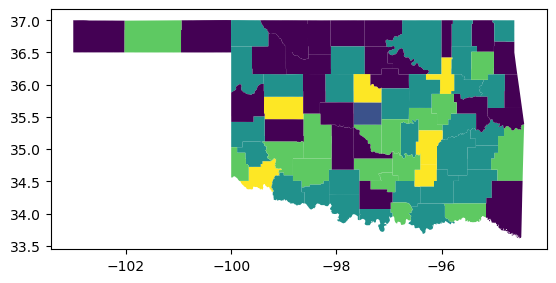

In [12]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]
labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()